In [1]:
import sys
sys.path.append('../../dependencies/')
import yaml
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
import geopandas as gp
import pandas as pd
from pathlib import Path
import numpy as np
from shapely.geometry import Point, LineString

# Let's check out the proposed domain to get some coordiante information

In [2]:
datapath = Path('../../data/sgn/')

In [3]:
domain = gp.read_file(datapath / 'shp' / 'Model_domain.shp')

### what's the projection?

In [4]:
domain.crs

<Projected CRS: EPSG:3003>
Name: Monte Mario / Italy zone 1
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.94, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: Italy zone 1
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### and what are the bounding points? We can navigate this using min and max x and y points because we know the rotation is anticlockwise

In [5]:
x,y = domain.geometry[0].exterior.coords.xy
xul, yul = x[np.argmin(x)],y[np.argmin(x)]
xtop, ytop = x[np.argmax(y)],y[np.argmax(y)]
xll, yll = x[np.argmin(y)],y[np.argmin(y)]
xlr,ylr = x[np.argmax(x)],y[np.argmax(x)]

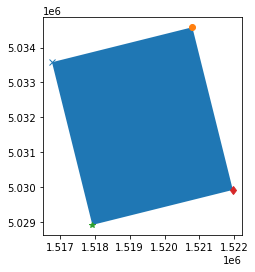

In [6]:
ax = domain.plot(color=None)
ax.plot(xul,yul, 'x')
ax.plot(xtop,ytop, 'o')
ax.plot(xll,yll,'*')
ax.plot(xlr,ylr,'d')

### calculate the angle of rotation from upper left and top vertices

In [7]:
opp_over_hyp = np.abs(ytop-yul)/np.sqrt((xtop-xul)**2+(ytop-yul)**2)

In [8]:
opp_over_hyp

0.2419218955996804

In [9]:
rot_angle = np.arcsin(opp_over_hyp)
rot_angle = float(rot_angle * 180/np.pi)
rot_angle

14.000000000000748

# calculate the total length and width

In [10]:
length = np.round(np.sqrt((xll-xul)**2+(yll-yul)**2), decimals=-1)
width = np.round(np.sqrt((xll-xlr)**2+(yll-ylr)**2), decimals=-1)


### check out the recharge and geology

In [11]:
rch = gp.read_file(datapath / 'shp' / 'Recharge_4.shp')
rch.columns

Index(['DESCR', 'RCH_mmy', 'geometry'], dtype='object')

<AxesSubplot:>

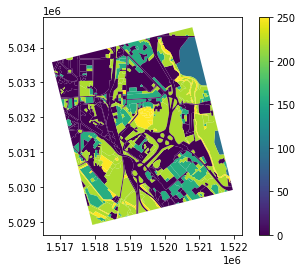

In [12]:
rch.plot(column = 'RCH_mmy', legend=True)


### it's easier if we burn this into a raster for `modflow-setup` to handle ATM

In [13]:
# open layer 2 bottom and read the metadata for the raster
bot2_rast = rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') 
rastermeta = bot2_rast.meta.copy()
rastermeta.update(compress='lzw') # set compression to be sure file is small as possible

In [14]:
# set up a tuple of geomoetry/k-value pairs from the geology shapefile
rchpolygons = ((geom,value) for geom, value in zip(rch.geometry, rch.RCH_mmy))
with rasterio.open(datapath/ 'raster' / 'rch.tif', 'w+', **rastermeta) as ofp:
    out_arr = ofp.read(1)
    
    rchraster = features.rasterize(shapes=rchpolygons,
                                       fill=-9999,
                                       out=out_arr,
                                       transform=ofp.transform)
    ofp.write_band(1,rchraster)

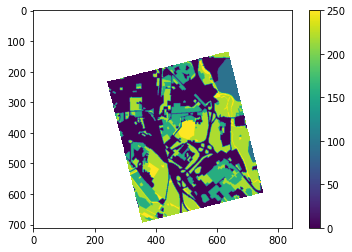

In [15]:
# confirm we wrote this ok
with rasterio.open(datapath/ 'raster' / 'rch.tif') as src:
    rch = src.read(1)
rch[rch<-1] = np.nan
plt.imshow(rch)
plt.colorbar()

### now let's check out the geology

In [16]:
geology = gp.read_file(datapath / 'shp' / 'Geology_250000_clip.shp')
geology.columns

Index(['COD', 'LITOLOGIA', 'geometry'], dtype='object')

<AxesSubplot:>

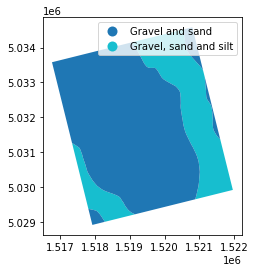

In [17]:
geology.plot(column = 'LITOLOGIA', legend=True)

### we can set starting Kh values as: 
Gravel and sand = 0.0045  
Gravel, sand and silt = 0.0023

In [18]:
geology['k'] = -999999
geology.loc[geology.LITOLOGIA == 'Gravel and sand', 'k'] = 0.0045
geology.loc[geology.LITOLOGIA == 'Gravel, sand and silt', 'k'] = 0.0023
assert geology.k.min()>0

<AxesSubplot:>

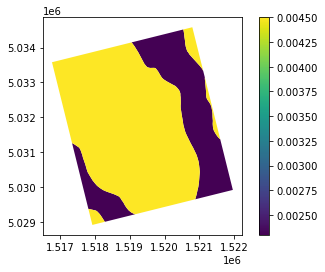

In [19]:
geology.plot(column='k', legend=True)

In [20]:
# set up a tuple of geomoetry/k-value pairs from the geology shapefile
geopolygons = ((geom,value) for geom, value in zip(geology.geometry, geology.k))
with rasterio.open(datapath/ 'raster' / 'k_field0.tif', 'w+', **rastermeta) as ofp:
    out_arr = ofp.read(1)
    
    georaster = features.rasterize(shapes=geopolygons,
                                       fill=-9999,
                                       out=out_arr,
                                       transform=ofp.transform)
    ofp.write_band(1,georaster)

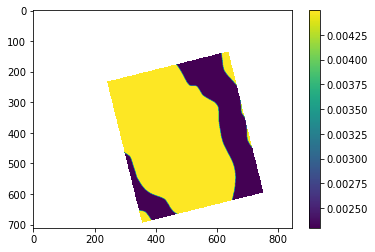

In [21]:
# confirm we wrote this ok
with rasterio.open(datapath/ 'raster' / 'k_field0.tif') as src:
    k0 = src.read(1)
k0[k0<-1] = np.nan
plt.imshow(k0)
plt.colorbar()

### for now, we will assign constant values to layers 2 and 3

In [22]:
k1 = np.ones_like(k0) * 1e-8 # aquitard
k2 = np.ones_like(k0) * 2.3e-3 # deep aquifer

In [23]:
with rasterio.open(datapath/ 'raster' / 'k_field1.tif', 'w+', **rastermeta) as ofp:
    ofp.write_band(1, k1)
with rasterio.open(datapath/ 'raster' / 'k_field2.tif', 'w+', **rastermeta) as ofp:
    ofp.write_band(1, k2)


### and let's see where the river is

In [24]:
riv = gp.read_file(datapath / 'shp' / 'River_Lambro.shp')
riv

,Id,Stage,geometry
0,0,103.0,"LINESTRING (1519819.286 5034332.958, 1519820.9..."


<AxesSubplot:>

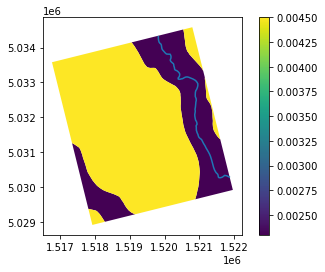

In [25]:
ax = geology.plot(column='k', legend=True)
riv.plot(ax=ax)

### we need to add some information to the river

#### first break up into a handful of segments

In [26]:
riv1 = riv.iloc[0].geometry

In [27]:
rivpts = [Point(i) for i in riv1.coords]
# add a starting point and ending point each outside the domain
newpt = Point(rivpts[0].coords[0][0],rivpts[0].coords[0][1]+150)
rivpts.insert(0,newpt)
newpt = Point(rivpts[-1].coords[0][0]+150,rivpts[-1].coords[0][1]-150)
rivpts.append(newpt)

In [28]:
rivsegs = []
totpts = len(rivpts)/10
previous_seg = 0
for i in range(1,10):
    tmppts = rivpts[previous_seg:int(i*totpts)]
    previous_seg = int(i*totpts)-1
    rivsegs.append(LineString(zip([c.coords[0][0] for c in tmppts],
                                 [c.coords[0][1] for c in tmppts])))
tmppts = rivpts[previous_seg:-1]
rivsegs.append(LineString(zip([c.coords[0][0] for c in tmppts],
                                 [c.coords[0][1] for c in tmppts])))

In [29]:
riv_divided = gp.GeoDataFrame({'geometry':rivsegs,
                               'segname': [i+1+1000 for i in range(len(rivsegs))]},
                                                                      crs=riv.crs)

<AxesSubplot:>

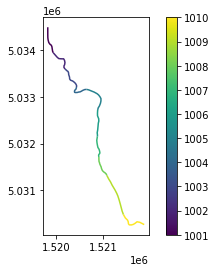

In [30]:
riv_divided.plot(column='segname', legend=True)

#### now set up routing

In [31]:
riv_divided ['from_id'] = [i+1000 for i in range(len(riv_divided))]
riv_divided.loc[0, 'from_id'] = 0
riv_divided ['to_id'] = [i+2+1000 for i in range(len(riv_divided))]
riv_divided.loc[9, 'to_id'] = 0
# wild guess on river width
riv_divided['streamwid'] = 15

In [32]:
riv_divided

,geometry,segname,from_id,to_id,streamwid
0,"LINESTRING (1519819.286 5034482.958, 1519819.2...",1001,0,1002,15
1,"LINESTRING (1519937.256 5033937.494, 1519964.7...",1002,1001,1003,15
2,"LINESTRING (1520189.139 5033590.360, 1520233.5...",1003,1002,1004,15
3,"LINESTRING (1520433.615 5033207.666, 1520420.9...",1004,1003,1005,15
4,"LINESTRING (1520646.129 5033156.866, 1520692.6...",1005,1004,1006,15
5,"LINESTRING (1520884.254 5032717.868, 1520880.0...",1006,1005,1007,15
6,"LINESTRING (1520877.481 5032147.086, 1520871.5...",1007,1006,1008,15
7,"LINESTRING (1520909.654 5031715.286, 1520910.5...",1008,1007,1009,15
8,"LINESTRING (1521080.681 5031320.061, 1521118.7...",1009,1008,1010,15
9,"LINESTRING (1521434.589 5030483.891, 1521474.3...",1010,1009,0,15


In [33]:
riv_divided.to_file(datapath / 'shp' / 'River_Lambro_segmented.shp')

## let's take a quick look at the raster data

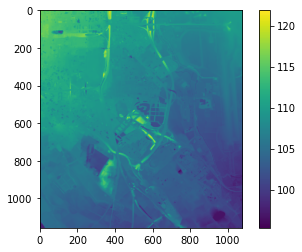

In [34]:
with rasterio.open(datapath/ 'raster' / 'DTM_domain.tif') as src:
    modtop = src.read(1)
plt.imshow(modtop)
plt.colorbar()

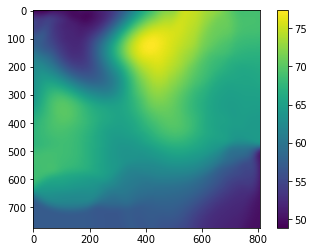

In [35]:
with rasterio.open(datapath/ 'raster' / 'Bott_L1_fix.tif') as src:
    bot1 = src.read(1)
plt.imshow(bot1)
plt.colorbar()

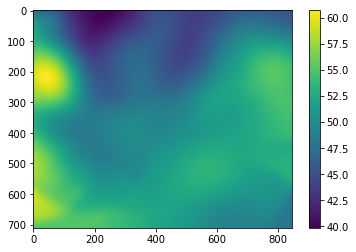

In [36]:
with rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') as src:
    bot2 = src.read(1)
plt.imshow(bot2)
plt.colorbar()

### we need a raster of the bottom of layer 2 kicked down by 60m to make the bottom of layer 3

In [37]:
# open layer 2 again and read the metadata for the raster
bot2_rast = rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') 
meta_lay3 = bot2_rast.meta.copy()
meta_lay3.update(compress='lzw') # set compression to be sure file is small as possible
bot2_rast.close()

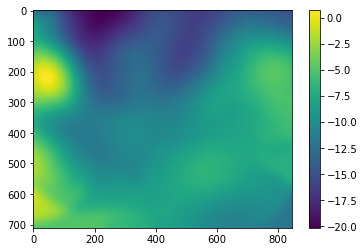

In [38]:
# now subtract 60m from layer 2 and write out layer 3
bot3 = bot2-60.
plt.imshow(bot3)
plt.colorbar()

In [39]:
with rasterio.open(datapath/ 'raster' / 'Bott_L3_fix.tif', 'w+', **meta_lay3) as ofp:
    ofp.write_band(1, bot3)
    

### now a quick check reading back in to make sure that worked

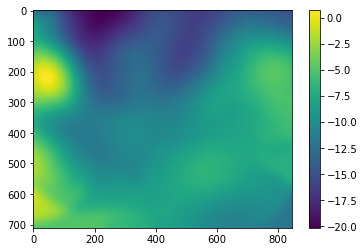

In [40]:
with rasterio.open(datapath/ 'raster' / 'Bott_L3_fix.tif') as src:
    bot3 = src.read(1)
plt.imshow(bot3)
plt.colorbar()

### we need a csv file for the well package

In [41]:
wells = gp.read_file(datapath / 'shp' / 'wells.shp')

<AxesSubplot:>

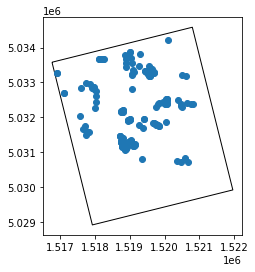

In [42]:
ax = domain.plot(facecolor="none", edgecolor='black')
wells.plot( ax=ax)

In [43]:
wells.columns

Index(['WellName', 'X', 'Y', 'TopLayer', 'BottomLaye', 'DefaultQ', 'geometry'], dtype='object')

In [44]:
wells.WellName = wells.WellName.apply(lambda x: x.lower())

In [45]:
well_metadata = pd.read_csv(datapath / 'wells_with_elev.dat', index_col=0)
well_metadata.head()

,cellid,q,boundname,laytop,laybot,layer,cell,laymidpt,rootname
0,"(0, 4736)",0.0,p1_ln__0,104.773590,69.462875,0,4736,17.655357,p1_ln
1,"(0, 4735)",0.0,p2_ln__0,104.723152,69.486488,0,4735,17.618332,p2_ln
2,"(0, 4742)",0.0,p3_ln__0,104.679207,69.459198,0,4742,17.610004,p3_ln
3,"(0, 4739)",0.0,p4_ln__0,104.633415,69.517403,0,4739,17.558006,p4_ln
4,"(0, 5138)",0.0,p5_ln__0,104.638702,69.421188,0,5138,17.608757,p5_ln


In [46]:
wells.head()

,WellName,X,Y,TopLayer,BottomLaye,DefaultQ,geometry
0,p1_ln,1.520070e+06,5.032527e+06,1,1,0.0,POINT (1520069.925 5032526.545)
1,p2_ln,1.520053e+06,5.032516e+06,1,1,0.0,POINT (1520053.252 5032516.080)
2,p3_ln,1.520072e+06,5.032513e+06,1,1,0.0,POINT (1520071.627 5032513.148)
3,p4_ln,1.520033e+06,5.032496e+06,1,1,0.0,POINT (1520033.339 5032495.666)
4,p5_ln,1.520070e+06,5.032489e+06,1,1,0.0,POINT (1520070.059 5032488.559)


#### trim out the non pumping wells

In [47]:
len(well_metadata)

183

In [48]:
well_metadata = well_metadata.loc[well_metadata.q != 0]
len(well_metadata)

78

In [49]:
well_metadata.head()

,cellid,q,boundname,laytop,laybot,layer,cell,laymidpt,rootname
53,"(0, 2196)",-0.005,636__0,110.001999,65.353310,0,2196,22.324345,636
54,"(2, 2196)",-0.005,636__2,49.060505,-10.939495,2,2196,30.000000,636
55,"(0, 1936)",-0.005,637__0,110.503960,65.559921,0,1936,22.472019,637
56,"(2, 1936)",-0.005,637__2,48.660793,-11.339207,2,1936,30.000000,637
57,"(0, 2217)",-0.001,808__0,107.334236,69.746376,0,2217,18.793930,808


In [50]:
well_data = well_metadata.merge(wells[['X','Y','WellName']], left_on='rootname', right_on='WellName')

In [51]:
well_data

,cellid,q,boundname,laytop,laybot,layer,cell,laymidpt,rootname,X,Y,WellName
0,"(0, 2196)",-0.0050,636__0,110.001999,65.353310,0,2196,22.324345,636,1.518019e+06,5.032596e+06,636
1,"(2, 2196)",-0.0050,636__2,49.060505,-10.939495,2,2196,30.000000,636,1.518019e+06,5.032596e+06,636
2,"(0, 1936)",-0.0050,637__0,110.503960,65.559921,0,1936,22.472019,637,1.518020e+06,5.032742e+06,637
3,"(2, 1936)",-0.0050,637__2,48.660793,-11.339207,2,1936,30.000000,637,1.518020e+06,5.032742e+06,637
4,"(0, 2217)",-0.0010,808__0,107.334236,69.746376,0,2217,18.793930,808,1.519055e+06,5.032822e+06,808
...,...,...,...,...,...,...,...,...,...,...,...,...
73,"(2, 7590)",-0.0095,19/19__2,51.490337,-8.509663,2,7590,30.000000,19/19,1.520824e+06,5.032384e+06,19/19
74,"(0, 7057)",-0.0095,19/20__0,104.024193,67.291756,0,7057,18.366219,19/20,1.520653e+06,5.032405e+06,19/20
75,"(2, 7057)",-0.0095,19/20__2,51.473099,-8.526901,2,7057,30.000000,19/20,1.520653e+06,5.032405e+06,19/20
76,"(0, 5637)",-0.0095,19/21__0,103.002068,68.493927,0,5637,17.254070,19/21,1.520382e+06,5.032503e+06,19/21


In [52]:
well_data = well_data.rename(columns = {'X':'x', 'Y':'y','laytop':'screen_top','laybot':'screen_botm'})

In [53]:
# need to add datetime for pumping
well_data['datetime'] = '2021-01-01'
well_data['enddatetime'] = '2021-12-31'

In [54]:
well_data

,cellid,q,boundname,screen_top,screen_botm,layer,cell,laymidpt,rootname,x,y,WellName,datetime,enddatetime
0,"(0, 2196)",-0.0050,636__0,110.001999,65.353310,0,2196,22.324345,636,1.518019e+06,5.032596e+06,636,2021-01-01,2021-12-31
1,"(2, 2196)",-0.0050,636__2,49.060505,-10.939495,2,2196,30.000000,636,1.518019e+06,5.032596e+06,636,2021-01-01,2021-12-31
2,"(0, 1936)",-0.0050,637__0,110.503960,65.559921,0,1936,22.472019,637,1.518020e+06,5.032742e+06,637,2021-01-01,2021-12-31
3,"(2, 1936)",-0.0050,637__2,48.660793,-11.339207,2,1936,30.000000,637,1.518020e+06,5.032742e+06,637,2021-01-01,2021-12-31
4,"(0, 2217)",-0.0010,808__0,107.334236,69.746376,0,2217,18.793930,808,1.519055e+06,5.032822e+06,808,2021-01-01,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,"(2, 7590)",-0.0095,19/19__2,51.490337,-8.509663,2,7590,30.000000,19/19,1.520824e+06,5.032384e+06,19/19,2021-01-01,2021-12-31
74,"(0, 7057)",-0.0095,19/20__0,104.024193,67.291756,0,7057,18.366219,19/20,1.520653e+06,5.032405e+06,19/20,2021-01-01,2021-12-31
75,"(2, 7057)",-0.0095,19/20__2,51.473099,-8.526901,2,7057,30.000000,19/20,1.520653e+06,5.032405e+06,19/20,2021-01-01,2021-12-31
76,"(0, 5637)",-0.0095,19/21__0,103.002068,68.493927,0,5637,17.254070,19/21,1.520382e+06,5.032503e+06,19/21,2021-01-01,2021-12-31


In [55]:
well_data[['q','x','y','boundname','screen_top','screen_botm', 'enddatetime','datetime','laymidpt']].to_csv(datapath / 'wells_nonzero.csv')

# Now we write the blocks for the model-building YML configuration file

# let's set a lateral discretization

In [56]:
dxdy = 50

In [57]:
# use the technique at this link to preserve order of the YML output
# to make it easier for human readability
#https://stackoverflow.com/questions/31605131/dumping-a-dictionary-to-a-yaml-file-while-preserving-order/31609484

from collections import OrderedDict
def represent_dictionary_order(self, dict_data):
    return self.represent_mapping('tag:yaml.org,2002:map', dict_data.items())
   

In [58]:
# start with an empty dictionary
config_data = OrderedDict()

In [59]:
# make subdictionaries for each section
# SIMULATION BLOCK 
config_data['simulation'] = dict()
config_data['simulation']['sim_name'] = f'sgn_{dxdy}_sim'
config_data['simulation']['sim_ws'] = '../../models/sgn_mfsetup'
config_data['simulation']['version'] = 'mf6'
config_data['simulation']['options'] = dict()
config_data['simulation']['options']['continue'] = True



In [60]:
# MODEL BLOCK
config_data['model'] = dict()
config_data['model']['external_path'] = './' 
config_data['model']['modelname'] = f'sgn_{dxdy}'
config_data['model']['relative_external_filepaths'] = True
config_data['model']['simulation'] = f'sgn_{dxdy}_sim'

# options subblock
config_data['model']['options'] = dict()
config_data['model']['options']['newton'] = True
config_data['model']['options']['newton_under_relaxation'] = True
config_data['model']['options']['print_input'] = True
config_data['model']['options']['save_flows'] = True
# packages block
config_data['model']['packages'] = ['dis', 'ims', 'ic', 'wel', 'oc', 'npf', 'rch', 'sfr']


In [61]:
config_data['intermediate_data'] = dict()
config_data['intermediate_data']['output_folder'] = 'original/'

In [62]:
# set up the grid
config_data['setup_grid'] = dict()
config_data['setup_grid']['epsg'] = domain.crs.to_epsg() # read in from the domain crs
config_data['setup_grid']['rotation'] = float(np.round(rot_angle, decimals=5)) # calculated above
config_data['setup_grid']['xoff'] = xll # calculated above - lower left corner
config_data['setup_grid']['yoff'] = yll # calculated above - lower left corner

In [63]:
# set up the discretization
config_data['dis'] = dict()

In [64]:
#dimensions block
config_data['dis']['dimensions'] = dict()
# from the calcs above and using the specified cell spacing
config_data['dis']['dimensions']['ncol'] = int(np.round(width/dxdy) )
config_data['dis']['dimensions']['nrow'] = int(np.round(length/dxdy) )
config_data['dis']['dimensions']['nlay'] = 3

config_data['dis']['drop_thin_cells'] =  True
config_data['dis']['minimum_layer_thickness'] = 1.0
config_data['dis']['remake_top'] = True

config_data['dis']['griddata'] = dict()
config_data['dis']['griddata']['delr'] = dxdy
config_data['dis']['griddata']['delc'] = dxdy

config_data['dis']['options'] = dict()
config_data['dis']['options']['length_units'] = 'meters'

In [65]:
# now the source data for the dimenstions block above
config_data['dis']['source_data'] = dict()
config_data['dis']['source_data']['top'] = dict()
config_data['dis']['source_data']['top']['filename'] = \
            str(datapath/ 'raster' / 'DTM_domain.tif')
config_data['dis']['source_data']['top']['elevation_units'] = 'meters'

config_data['dis']['source_data']['botm'] = dict()
config_data['dis']['source_data']['botm']['filenames'] = dict()
config_data['dis']['source_data']['botm']['filenames'][0] =\
            str(datapath/ 'raster' / 'Bott_L1_fix.tif')
config_data['dis']['source_data']['botm']['filenames'][1] =\
            str(datapath/ 'raster' / 'Bott_L2_fix.tif')
config_data['dis']['source_data']['botm']['filenames'][2] =\
            str(datapath/ 'raster' / 'Bott_L3_fix.tif')


config_data['dis']['source_data']['botm']['elevation_units'] = 'meters'

In [66]:
# time discretization - simple for steady state
config_data['tdis'] = dict()
config_data['tdis']['options'] = dict()
config_data['tdis']['options']['start_date_time'] = '2021-01-01'
config_data['tdis']['options']['time_units'] = 'seconds'
config_data['tdis']['perioddata'] = dict()

config_data['tdis']['perioddata']['nper'] = 1
config_data['tdis']['perioddata']['perlen'] = 3.154e+7
config_data['tdis']['perioddata']['nstp'] = 1
config_data['tdis']['perioddata']['steady'] = True
config_data['tdis']['perioddata']['tsmult'] = 1


In [67]:
# set in initial conditions as top of the model  for now
config_data['ic'] = dict()
config_data['ic']['strt_filename_fmt'] = \
    str(datapath/ 'raster' / 'DTM_domain.tif')



In [68]:
# add in the wells
wellfile = str(datapath / 'wells_nonzero.csv')
config_data['wel'] = dict()
config_data['wel']['options'] = dict()
config_data['wel']['options']['print_input'] = True
config_data['wel']['options']['print_flows'] = True
config_data['wel']['options']['save_flows'] = True

config_data['wel']['source_data'] = dict()
config_data['wel']['source_data']['csvfiles'] = dict()

config_data['wel']['source_data']['csvfiles']['filenames'] = [wellfile]
config_data['wel']['source_data']['csvfiles']['volume_units'] = 'meters'

config_data['wel']['source_data']['csvfiles']['time_units'] = 'seconds'
config_data['wel']['source_data']['csvfiles']['data_column'] = 'q'
config_data['wel']['source_data']['csvfiles']['id_column'] = 'boundname'
config_data['wel']['source_data']['csvfiles']['datetime_column'] = 'datetime'
config_data['wel']['source_data']['csvfiles']['end_datetime_column'] = 'enddatetime'
config_data['wel']['source_data']['csvfiles']['period_stats'] = dict()
config_data['wel']['source_data']['csvfiles']['period_stats'][0] = \
    ['mean','2020-12-31', '2022-01-01']




config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution'] = dict()
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['across_layers'] = False
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['distribute_by'] = 'transmissivity'
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['screen_top_col'] = 'screen_top'
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['screen_botm_col'] = 'screen_botm'
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['screen_botm_col'] = 'screen_botm'

#config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['minimum_layer_thickess'] = 10


In [69]:
# output control
config_data['oc'] = dict()
config_data['oc']['budget_fileout_fmt'] = '{}.cbc'
config_data['oc']['head_fileout_fmt'] = '{}.hds'
config_data['oc']['saverecord'] = dict()
config_data['oc']['saverecord'][0] = dict()

config_data['oc']['saverecord'][0]['budget'] = 'last'
config_data['oc']['saverecord'][0]['head'] = 'last'



In [70]:
#node property flow
geology_file = str(datapath / 'raster' / 'k_field{}.tif')
config_data['npf'] = dict()
config_data['npf']['source_data'] = dict()
config_data['npf']['source_data']['k'] = dict()

config_data['npf']['source_data']['k']['filenames'] = dict()
config_data['npf']['source_data']['k']['filenames'][0] = geology_file.format(0)
config_data['npf']['source_data']['k']['filenames'][1] = geology_file.format(1)
config_data['npf']['source_data']['k']['filenames'][2] = geology_file.format(2)



In [71]:
# recharge
rch_file = str(datapath / 'raster' / 'rch.tif')
config_data['rch'] = dict()
config_data['rch']['options'] = dict()
config_data['rch']['options']['print_output'] = True
config_data['rch']['options']['print_flows'] = False
config_data['rch']['options']['save_flows'] = True
config_data['rch']['options']['readasarrays'] = True
config_data['rch']['source_data'] = dict()
config_data['rch']['source_data']['recharge'] = dict()
config_data['rch']['source_data']['recharge']['filenames'] = dict()
config_data['rch']['source_data']['recharge']['filenames'][0] = rch_file
config_data['rch']['source_data']['recharge']['length_units'] = 'millimeters'
config_data['rch']['source_data']['recharge']['time_units'] = 'years'
config_data['rch']['source_data']['recharge']['period_stats'] = dict()
config_data['rch']['source_data']['recharge']['period_stats'][0] = \
    ['mean','2020-12-31', '2022-01-01']


In [ ]:
# streamflow routing
rivfile = str(datapath / 'shp' / 'River_Lambro_segmented.shp')

In [ ]:
# for SFR observations, we need to make a CSV file with the segments identified
inriv = gp.read_file(rivfile)
inriv.head()

In [ ]:
rivsegfile = str(datapath / 'csv' / 'river_segments.csv')
inriv['segname'].to_csv(rivsegfile)

In [75]:

config_data['sfr'] = dict()
config_data['sfr']['source_data'] = dict()
config_data['sfr']['source_data']['flowlines'] = dict()
config_data['sfr']['source_data']['flowlines']['filename'] = rivfile
config_data['sfr']['source_data']['flowlines']['id_column'] = 'segname'
config_data['sfr']['source_data']['flowlines']['routing_column'] = 'to_id'
config_data['sfr']['source_data']['flowlines']['width1'] = 'streamwid'
config_data['sfr']['source_data']['flowlines']['width2'] = 'streamwid'


config_data['sfr']['source_data']['dem'] = dict()
config_data['sfr']['source_data']['dem']['filename'] = \
         str(datapath/ 'raster' / 'DTM_domain.tif')
config_data['sfr']['source_data']['dem']['elevation_units'] = 'meters'

config_data['sfr']['source_data']['observations'] = dict()
config_data['sfr']['source_data']['observations']['filename'] = rivsegfile
config_data['sfr']['source_data']['observations']['obstype'] = ['sfr','outflow', 'downstream-flow','ext-outflow']
config_data['sfr']['source_data']['observations']['line_id_column'] = 'segname'
config_data['sfr']['source_data']['observations']['obsname_column'] = 'segname'

config_data['sfr']['set_streambed_top_elevations_from_dem'] = True



In [76]:
# solver settings
config_data['ims'] = dict()
config_data['ims']['options'] = dict()
config_data['ims']['options']['print_options'] = 'all'
config_data['ims']['options']['complexity'] = 'moderate'
config_data['ims']['nonlinear'] = dict()
config_data['ims']['nonlinear']['outer_dvclose'] = 0.01
config_data['ims']['linear'] = dict()
config_data['ims']['linear']['inner_dvclose'] = 0.00001


In [77]:
yaml.add_representer(OrderedDict, represent_dictionary_order)
with open('sgn_config.yml', 'w') as outfile:
    yaml.dump(config_data, outfile, default_flow_style=False)